In [1]:
import gc
from pathlib import Path
import cudf
import pandas as pd
import numpy as np
# from tqdm import tqdm 
import matplotlib.pyplot as plt

In [9]:
path = Path('../input/h-and-m-personalized-fashion-recommendations')
customers = cudf.read_csv(path/'customers.csv')
# articles = cudf.read_csv(path/'articles.csv')
# trans = cudf.read_csv(path/'transactions_train.csv')

In [11]:
#reducing dataset size by random sampling (most plots remain the same with 1000 roes samples... stats rules!!!)
toytrain = trans.sample(frac=0.001, axis=0 )
display(toytrain)
toytrain.info()

,t_dat,customer_id,article_id,price,sales_channel_id
10471279,2019-05-19,103afb633e34a1599e955c6559b198505544cdc2f8047e...,399223024,0.030492,1
11498645,2019-06-07,5c185798447d38765860584eedbc35278ed2e723cb353f...,214844003,0.002814,1
6319534,2019-02-18,1f619b15225bc1ca0cd9b6bc019f53a88c8797350a7f92...,707147001,0.016932,2
3250615,2018-11-30,9e8211b4ae240c287f837f80580b05de1c4a002eb1795d...,716956001,0.050831,2
7602583,2019-03-20,9f7aa7e0cecf0833248ff6841fe1002f60fd3c66e5ea80...,569355014,0.028237,2
...,...,...,...,...,...
28548377,2020-07-03,9b6e97cef8966509fef4b0f9b9d7e70ada4aa8a9378bfb...,889627001,0.050831,2
29819437,2020-08-02,a271175ddbeb811d7a19c7869ca0f020e2a1b13af415e6...,843498003,0.027102,1
183450,2018-09-24,6093a2d3f4a3ba1649d86271120419da99d697ec83e642...,156231001,0.005627,1
28669580,2020-07-06,68eb75db3106029b4656291d196c429af7787fcfe85bec...,767032001,0.011627,2


<class 'cudf.core.dataframe.DataFrame'>
Int64Index: 31788 entries, 10471279 to 12237128
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   t_dat             31788 non-null  object
 1   customer_id       31788 non-null  object
 2   article_id        31788 non-null  int64
 3   price             31788 non-null  float64
 4   sales_channel_id  31788 non-null  int64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.5+ MB


<Axes: xlabel='t_dat'>

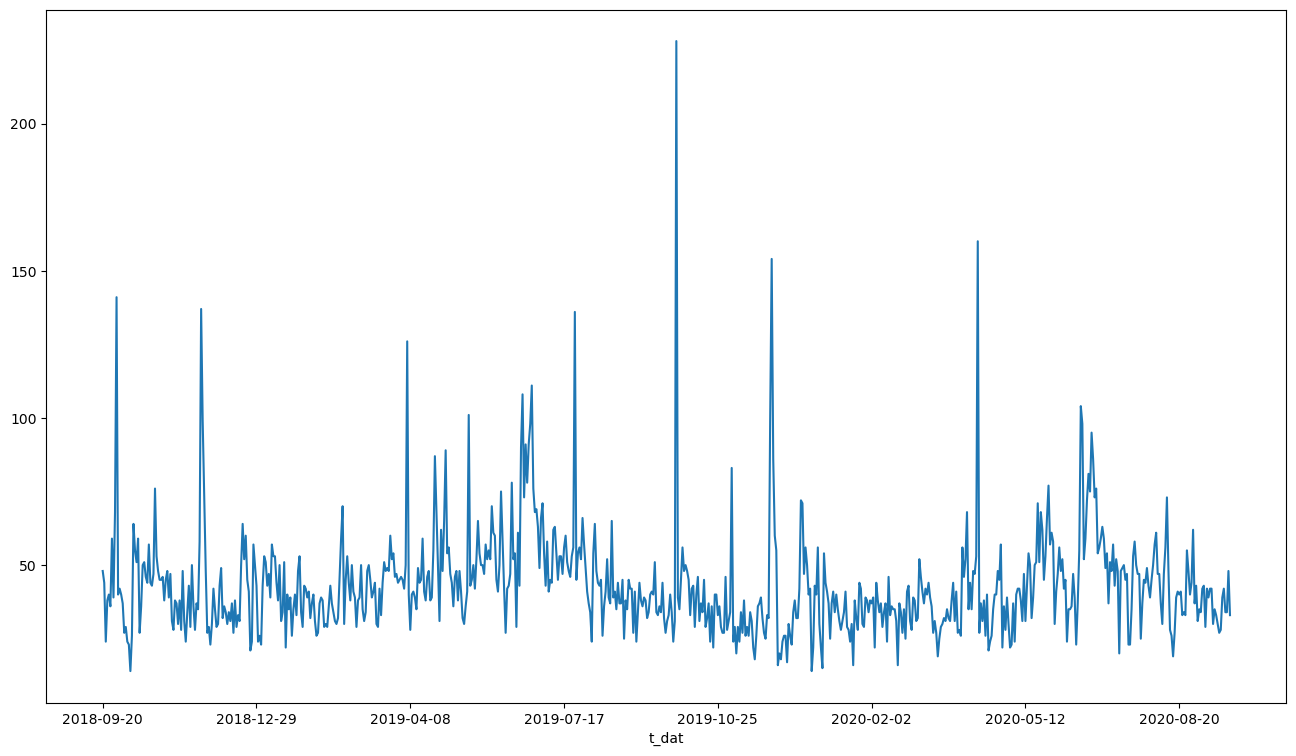

In [6]:
plt.figure(figsize=(16, 9))
toytrain.to_pandas().groupby(["t_dat"])["article_id"].count().plot()

In [12]:
#nicer formating for pandas tables

toyarticles = customers.copy()
toyarticles = toyarticles.to_pandas()
toyarticles.describe(include='all').T.sort_values(by='std' , ascending = False)\
.style.background_gradient(cmap='GnBu')\
.bar(subset=["max"], color='#F8766D')\
.bar(subset=["mean",], color='#00BFC4')
                    

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1356119.000000,nan,nan,nan,36.386965,14.313628,16.000000,24.000000,32.000000,49.000000,99.000000
FN,476930.000000,nan,nan,nan,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Active,464404.000000,nan,nan,nan,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
customer_id,1371980,1371980,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,1,nan,nan,nan,nan,nan,nan,nan
club_member_status,1365918,3,ACTIVE,1272491,nan,nan,nan,nan,nan,nan,nan
fashion_news_frequency,1355971,4,NONE,877711,nan,nan,nan,nan,nan,nan,nan
postal_code,1371980,352899,2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c,120303,nan,nan,nan,nan,nan,nan,nan


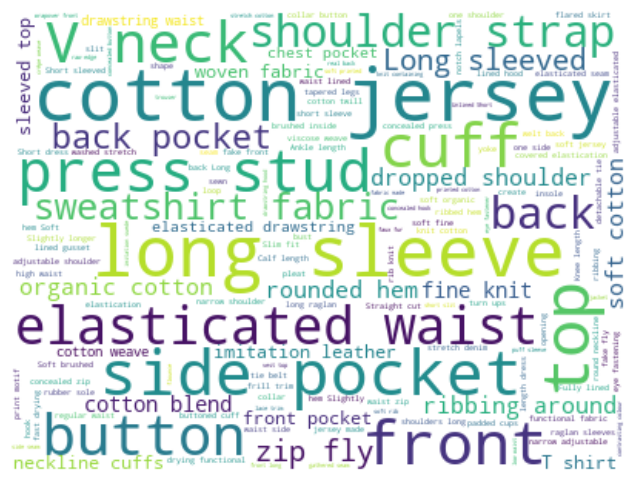

In [3]:
import nltk
from wordcloud import WordCloud #, STOPWORDS internal set used by the function by default

words_raw = articles['detail_desc'].dropna().to_pandas().apply(nltk.word_tokenize)
bag_of_words = " ".join(words_raw.explode())

fig, ax1 = plt.subplots(figsize=(8,6))
wordcloud = WordCloud( background_color="white", height=300, contour_width=3).generate(bag_of_words) #stopwords=stopwords
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

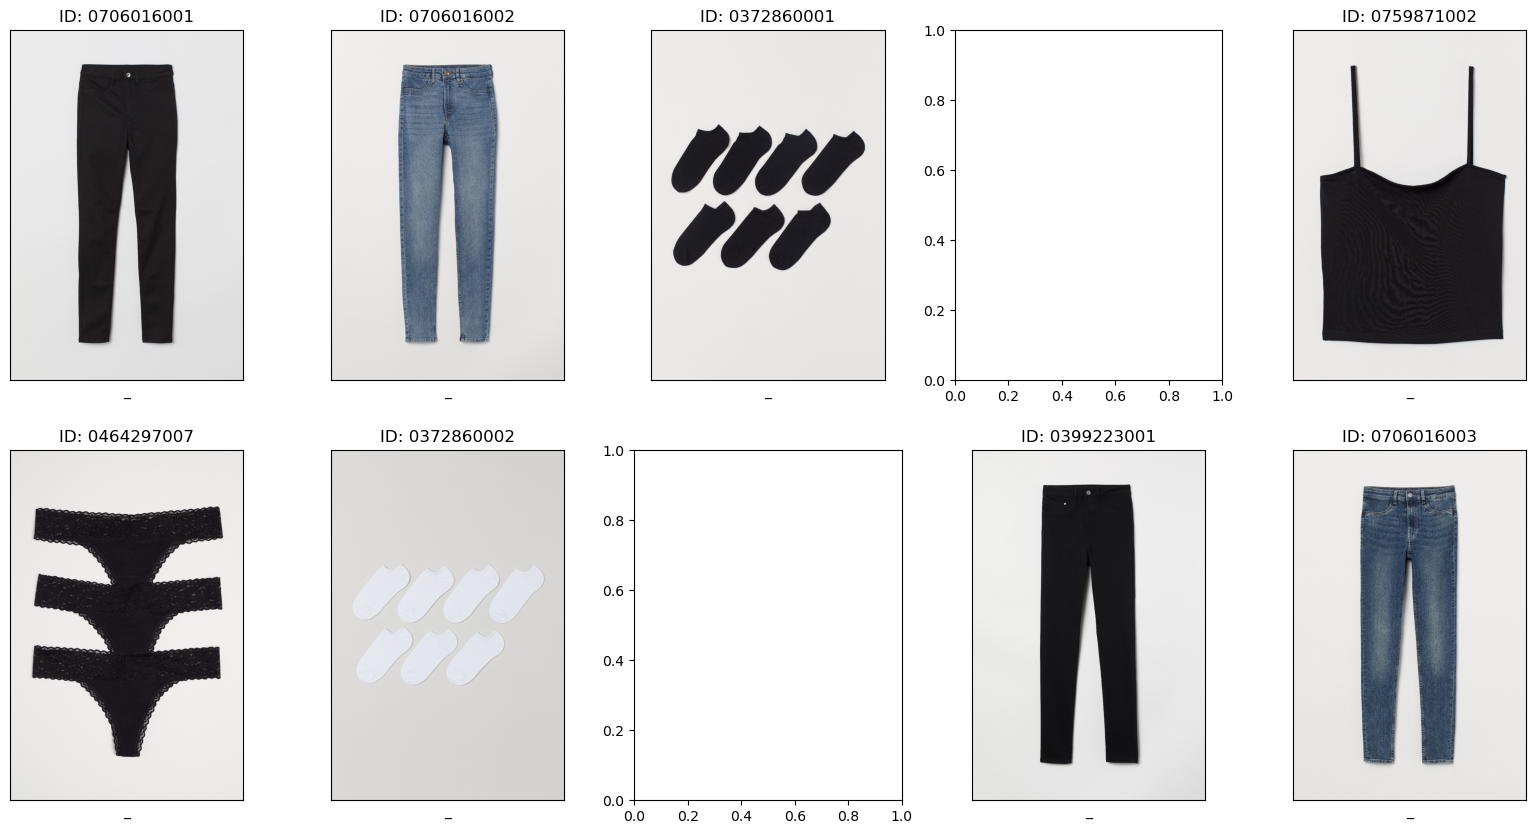

In [8]:
#build custom display function for multiple images
from PIL import Image
top10 = trans.groupby('article_id').sales_channel_id.count().nlargest(10).index
f, ax = plt.subplots(2, 5, figsize=(20, 10))
ax = ax.flatten() #to plot on more than one row with no double indx
for aid, a in zip(top10.to_arrow(), ax):
    faid = '0' + str(aid)
    fp = path/'images'/faid[:3]/(faid+'.jpg')
    if fp.exists():
        im = Image.open(fp)
        a.imshow(im)   
        a.set_title(f'ID: {faid}')
        a.set_xticks([], [])
        a.set_yticks([], [])
        a.grid(False)
        a.set_xlabel('_', fontsize=10)

In [ ]:
import matplotlib.ticker as ticker
import seaborn as sns
toycust = customers.copy()

f, ax = plt.subplots(figsize=(10, 5))
ax = sns.histplot(toycust.to_pandas(), x='age', bins=toycust.age.nunique(), color='magenta', stat='percent')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
median = toycust['age'].median()
ax.axvline(x=median, color="green", ls="--")
ax.text(median, 3.5, 'median: {}'.format(round(median,1)), rotation='vertical', ha='right')
ax.text(40, 8, 'Distribution of customers age', color='black', fontsize=10, ha='left', va='bottom', weight='bold', style='italic')
plt.show()

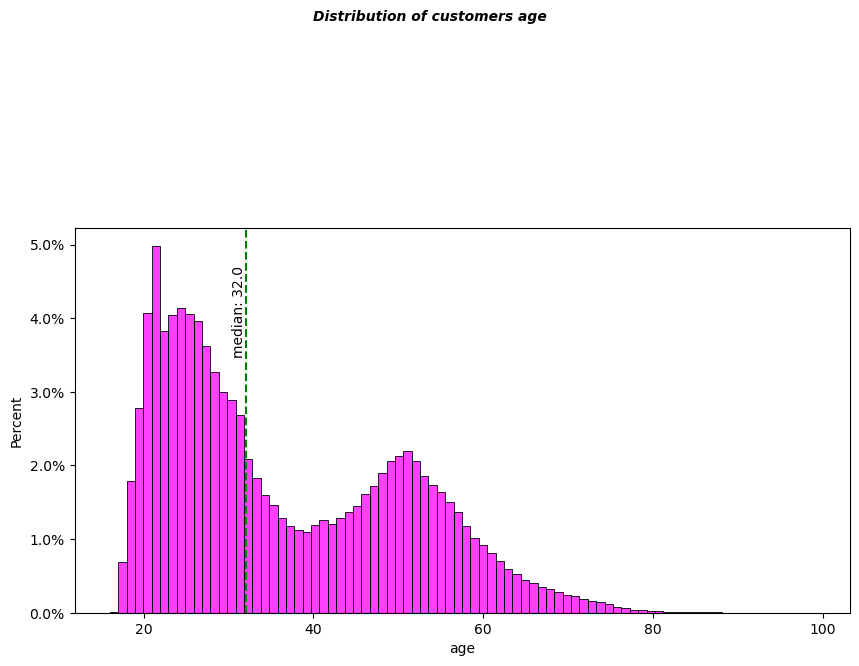

In [10]:
import matplotlib.ticker as ticker
import seaborn as sns
toycust = customers.copy()

f, ax = plt.subplots(figsize=(10, 5))
ax = sns.histplot(toycust.to_pandas(), x='age', bins=toycust.age.nunique(), color='magenta', stat='percent')
ax.yaxis.set_major_formatter(ticker.PercentFormatter())
median = toycust['age'].median()
ax.axvline(x=median, color="green", ls="--")
ax.text(median, 3.5, 'median: {}'.format(round(median,1)), rotation='vertical', ha='right')
ax.text(40, 8, 'Distribution of customers age', color='black', fontsize=10, ha='left', va='bottom', weight='bold', style='italic')
plt.show()

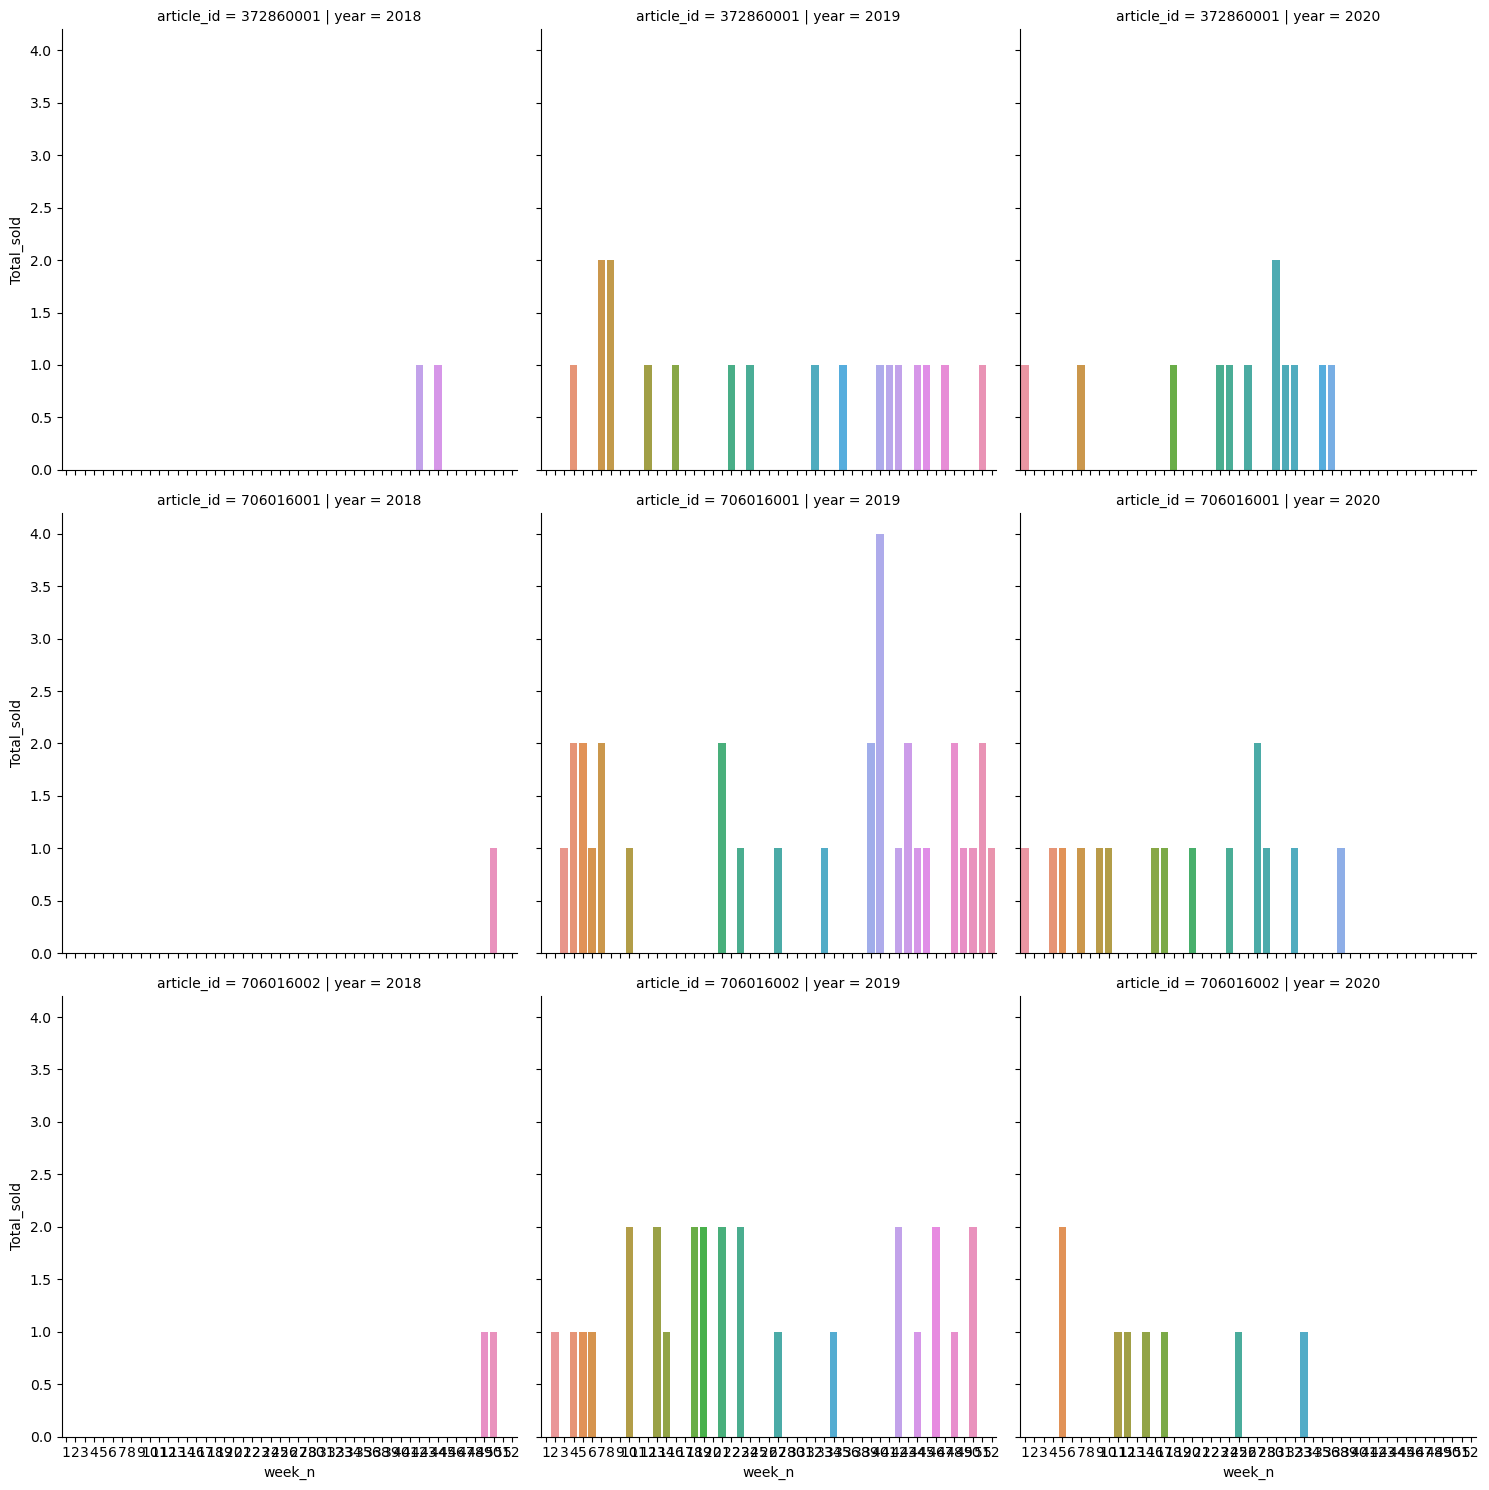

In [13]:
toytrain['t_dat'] = cudf.to_datetime(toytrain['t_dat'])
toytrain['week_n'] = toytrain.t_dat.to_pandas().dt.isocalendar().week
toytrain['year'] = toytrain.t_dat.dt.year
sold_per_week = toytrain.groupby(['year', 'week_n', 'article_id']).sales_channel_id.count().reset_index()
sold_per_week.rename({'sales_channel_id': 'Total_sold'}, axis=1, inplace=True)

generalist = ['0706016001', '0706016002', '0372860001', '0610776002', '0759871002', '0464297007', '0372860002', '0610776001', '0399223001', '0706016003', '0720125001', '0156231001'] 
gl = [int(x) for x in generalist[:3]]
mainitems = sold_per_week.loc[sold_per_week.article_id.isin(gl)]
sns.catplot(x="week_n", y="Total_sold", col="year",row = 'article_id',  kind="bar", data=mainitems.to_pandas())

In [ ]:
pd.options.display.max_rows = None 
pd.options.display.max_columns = None
# pd.set_option('display.float_format', '{:.4f}'.format) 
pd.options.display.float_format = '{:.4f}'.format

In [14]:
train = trans.copy()
def mbreak(s):
    return s.to_pandas().sort_values().diff().max().days  
breaks = train.groupby('article_id').t_dat.apply(mbreak)
d=range(30, 720, 30)
for i in tqdm(d):
    print(f'total {(breaks<i).sum()} items {(breaks<i).mean()*100:.2f}% for {i} days')

/opt/conda/lib/python3.10/site-packages/cudf/core/groupby/groupby.py:1169: RuntimeWarning: GroupBy.apply() performance scales poorly with number of groups. Got 104547 groups. Some functions may perform better by passing engine='jit'
  warnings.warn(


TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [ ]:
pd.options.display.max_rows = None 
pd.options.display.max_columns = None
# pd.set_option('display.float_format', '{:.4f}'.format) 
pd.options.display.float_format = '{:.4f}'.format

In [15]:
1+1

2